# Purpose

Notebook used to track the performance of the following [investment portfolio](https://docs.google.com/spreadsheets/d/1EZj5M7dXGy-48i0PydZQa5gpUOYCQHDFRBlp_rU1sdo/edit#gid=1104553850).

Requires updating the `eval_date` variable.

# Imports/Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
from dateutil.relativedelta import relativedelta

benchmark_ticker = 'SPY'
eval_date = dt.date(2023, 10, 16) # make sure is a valid trading day at least one day before current day

# Get Current Prices

In [2]:
investments = pd.read_csv('../Portfolio/investments.csv')
investments['weights'] = investments['initial_investment'] / investments['initial_investment'].sum()
initial_investment = investments['initial_investment'].sum()
investments.head()

,investment_type,GCIS_sector,name,country_of_origin,ticker,price_per_unit,initial_investment,number_of_units,weights
0,stocks,Energy,Exxon Mobil Corp,U.S.,XOM,116.70,400000,3427.592117,0.0500
1,stocks,Energy,PetroChina Co Ltd,China,PCCYF,0.66,400000,606060.606100,0.0500
2,stocks,Energy,NextEra Energy Inc.,U.S.,NEE,68.64,200000,2913.752914,0.0250
3,stocks,Materials,BHP Group Ltd,Austrailia,BHP,58.45,100000,1710.863986,0.0125
4,stocks,Materials,Air Products & Chemicals Inc,U.S.,APD,302.11,100000,331.005263,0.0125


In [3]:
start_date = dt.date(2023, 9, 18) # make sure is a valid trading day

summary = []
# have to make separate dataframes because crypto markets don't close

for index, row in investments.iterrows():
    ticker = row['ticker']
    tmp = yf.Ticker(ticker)
    pps_i = tmp.history(start=start_date, end=start_date + relativedelta(days=1))['Close'].values[0]
    pps_f = tmp.history(start=eval_date, end=eval_date + relativedelta(days=1))['Close'].values[0]
    summary.append([ticker, pps_i, pps_f])

summary = pd.DataFrame(summary, columns=['ticker', 'pps_i', 'pps_f'])

# Calc Gains/Losses 

In [4]:
summary['return'] = ((summary['pps_f'] - summary['pps_i']) / summary['pps_i']) * 100

summary = pd.merge(summary, 
                      investments[['ticker','initial_investment', 'investment_type', 'GCIS_sector']],
                      how='inner', on='ticker')

summary['position'] = (1 + summary['return'] / 100) * summary['initial_investment']
summary['gl'] = summary['position'] - summary['initial_investment']
summary['gl_pct'] = ((summary['position'] - summary['initial_investment']) / summary['initial_investment']) * 100

# Summary Report

In [5]:
position = summary['position'].sum()
gl = position - initial_investment
gl_pct = (gl / initial_investment) * 100
print(f'Current Portfolio Value: ${position:,.2f}')
print(f'Current gain/loss (value): ${gl:,.2f}')
print(f'Current gain/loss (%): {gl_pct:.2f}%')

Current Portfolio Value: $7,741,379.40
Current gain/loss (value): $-258,620.60
Current gain/loss (%): -3.23%


# Plots

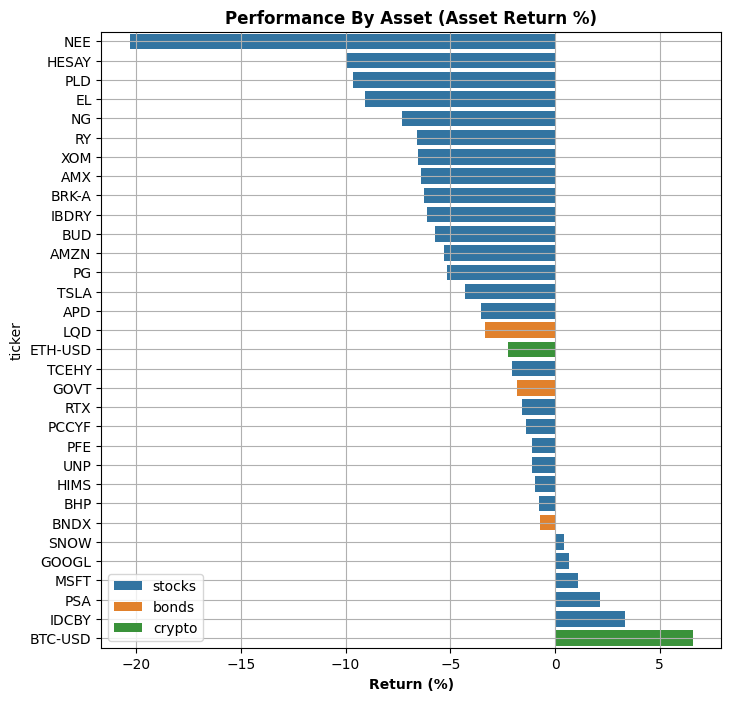

In [6]:
plt.figure(figsize=(8,8))

plt_data = summary.sort_values(by='return')
sns.barplot(data=plt_data, x='return', y='ticker', hue='investment_type', orient='h')
plt.xlabel('Return (%)', fontweight='bold')
plt.title('Performance By Asset (Asset Return %)', fontweight='bold')
plt.legend(loc='lower left')
plt.grid()
plt.show()

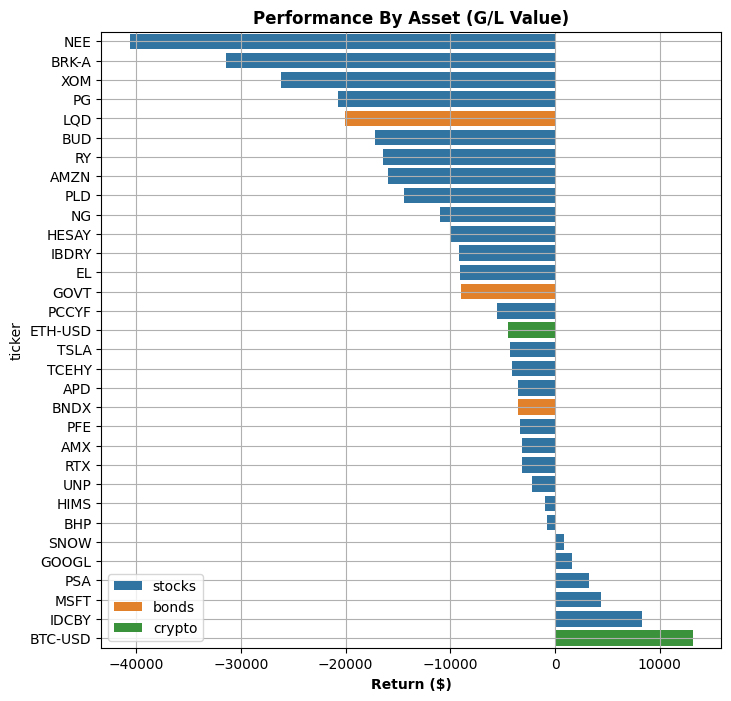

In [7]:
plt.figure(figsize=(8,8))

plt_data = summary.sort_values(by='gl')
sns.barplot(data=plt_data, x='gl', y='ticker', hue='investment_type', orient='h')
plt.xlabel('Return ($)', fontweight='bold')
plt.title('Performance By Asset (G/L Value)', fontweight='bold')
plt.legend(loc='lower left')
plt.grid()
plt.show()

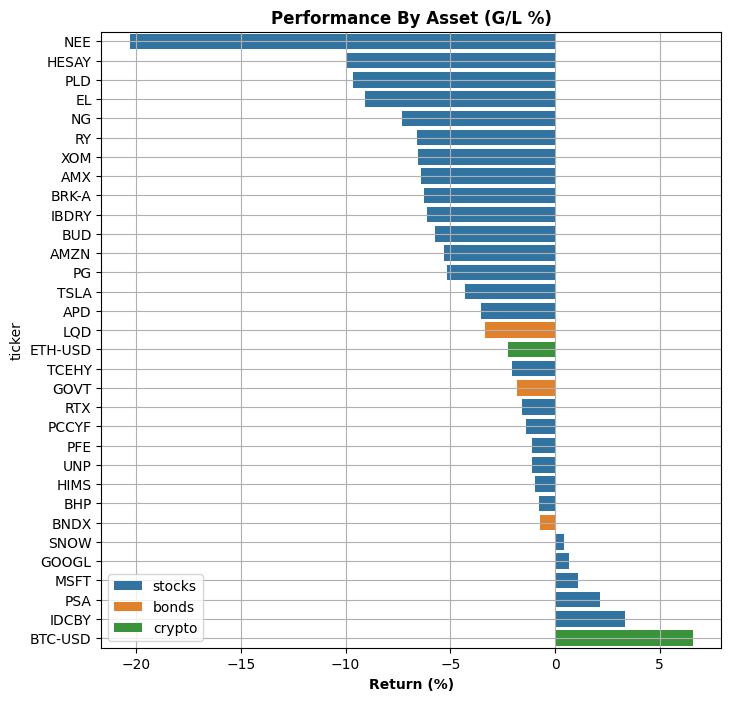

In [8]:
plt.figure(figsize=(8,8))

plt_data = summary.sort_values(by='gl_pct')
sns.barplot(data=plt_data, x='gl_pct', y='ticker', hue='investment_type', orient='h')
plt.xlabel('Return (%)', fontweight='bold')
plt.title('Performance By Asset (G/L %)', fontweight='bold')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Benchmark Comparison

In [9]:
tmp = yf.Ticker('SPY')
pps_i = tmp.history(start=start_date, end=start_date + relativedelta(days=1))['Close'].values[0]
pps_f = tmp.history(start=eval_date, end=eval_date + relativedelta(days=1))['Close'].values[0]
bm_gl_pct = ((pps_f - pps_i) / pps_i) * 100
bm_position = (1 + bm_gl_pct / 100) * initial_investment
bm_gl = bm_position - initial_investment

In [10]:
bm_stats = [bm_position, bm_gl, bm_gl_pct]
portfolio_stats = [position, gl, gl_pct]
combined = []
combined.append(portfolio_stats)
combined.append(bm_stats)

bm_comparison = pd.DataFrame(combined, columns=['Current Position', 'G/L Value', 'G/L %'])
bm_comparison.index = ['Portfolio', 'Benchmark']
pd.options.display.float_format = '{:,.2f}'.format
bm_comparison

,Current Position,G/L Value,G/L %
Portfolio,"7,741,379.40","-258,620.60",-3.23
Benchmark,"7,863,129.25","-136,870.75",-1.71
